In [1]:
import re
import torch
import detector
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('data/translated/bleu_table.csv', index_col=0)

## Utility functions

In [3]:
def plot_confusion_matrix(true_labels, prediction): 
    cm_data = confusion_matrix(true_labels, prediction)
    df_cm = pd.DataFrame(cm_data, columns=np.unique(true_labels), index = np.unique(true_labels))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

## Filter problematic rows and columns

In [4]:
filtered = data[data.len > 10]
filtered = filtered.reset_index(drop=True)
filtered = filtered.drop(columns=['T2-T3_en', 'T2-T3_es', 'T2-T3_fr', 'T2-T3_de'])

In [5]:
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,1.000000e+00,1.000000,0.495827,1.000000,0.0,0.0,0.631692,1.000000,2.0,0.0,17.0
1,7.361703e-01,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,2.0,0.0,15.0
2,7.309044e-01,0.902514,0.850931,1.000000,0.0,0.0,0.874341,1.000000,2.0,0.0,30.0
3,8.114530e-01,1.000000,1.000000,1.000000,0.0,0.0,0.550258,0.921960,2.0,0.0,46.0
4,2.586714e-11,0.658037,0.819978,0.857573,0.0,0.0,0.611736,0.440588,2.0,0.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...
53493,1.000000e+00,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,2.0,3.0,25.0
53494,6.734648e-01,0.750769,0.805558,1.000000,0.0,0.0,0.648288,0.634192,2.0,3.0,24.0
53495,7.186970e-01,0.625654,0.564882,1.000000,0.0,0.0,0.401919,0.509459,2.0,3.0,26.0
53496,5.060645e-01,1.000000,1.000000,1.000000,0.0,0.0,0.769192,1.000000,2.0,3.0,31.0


In [6]:
norm_data = pd.get_dummies(filtered, columns=['src'])
scaler = MinMaxScaler()
lengths = scaler.fit_transform(norm_data['len'].values.reshape(-1, 1))
norm_data['len'] = lengths
norm_data['origin'] = norm_data['origin'].astype(int)
norm_data

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,origin,len,src_0.0,src_1.0,src_2.0,src_3.0
0,1.000000e+00,1.000000,0.495827,1.000000,0.0,0.0,0.631692,1.000000,0,0.027907,0,0,1,0
1,7.361703e-01,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0,0.018605,0,0,1,0
2,7.309044e-01,0.902514,0.850931,1.000000,0.0,0.0,0.874341,1.000000,0,0.088372,0,0,1,0
3,8.114530e-01,1.000000,1.000000,1.000000,0.0,0.0,0.550258,0.921960,0,0.162791,0,0,1,0
4,2.586714e-11,0.658037,0.819978,0.857573,0.0,0.0,0.611736,0.440588,0,0.367442,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53493,1.000000e+00,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,3,0.065116,0,0,1,0
53494,6.734648e-01,0.750769,0.805558,1.000000,0.0,0.0,0.648288,0.634192,3,0.060465,0,0,1,0
53495,7.186970e-01,0.625654,0.564882,1.000000,0.0,0.0,0.401919,0.509459,3,0.069767,0,0,1,0
53496,5.060645e-01,1.000000,1.000000,1.000000,0.0,0.0,0.769192,1.000000,3,0.093023,0,0,1,0


## Training: Neural Network

In [25]:
dummy_y = [0] * len(norm_data.index)
X_train, X_test, y_train, y_test = train_test_split(norm_data, dummy_y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,origin,len,src_0.0,src_1.0,src_2.0,src_3.0
3231,0.793756,1.000000,0.915710,1.000000,0.000000,0.000000,0.609901,0.859089,0,0.097674,0,0,1,0
41582,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3,0.004651,1,0,0,0
46119,0.914406,1.000000,0.731130,0.786052,0.000000,0.000000,0.643680,0.723384,1,0.176744,0,0,1,0
12081,0.625654,1.000000,0.000000,0.000000,0.810593,0.912759,0.700158,1.000000,0,0.065116,0,1,0,0
22311,0.765733,0.834061,0.000000,0.000000,0.600920,1.000000,1.000000,1.000000,3,0.060465,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.608534,0.890173,0.000000,0.000000,0.657362,0.863303,0.372946,0.736763,0,0.144186,0,1,0,0
44732,0.637162,1.000000,1.000000,1.000000,0.000000,0.000000,0.609582,1.000000,1,0.106977,0,0,1,0
38158,0.432406,0.727165,0.672455,0.032486,0.543576,0.023181,0.000000,0.000000,1,0.097674,0,0,0,1
860,1.000000,1.000000,0.842363,1.000000,0.000000,0.000000,0.476062,0.290715,0,0.009302,0,0,1,0


In [8]:
dataset = detector.BLEUDataset(X_train)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.float()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
network.to(device)

Classifier(
  (hidden0): Linear(in_features=13, out_features=18, bias=True)
  (hidden1): Linear(in_features=18, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
detector.train_classifier(network, loader, 1000, 40, device)

accuracy
Epoch 733 took: 4.644s
Epoch 734, iter 40: 1.3312 loss | 32.4050% accuracy
Epoch 734 took: 5.226s
Epoch 735, iter 40: 1.3316 loss | 32.3125% accuracy
Epoch 735 took: 5.012s
Epoch 736, iter 40: 1.3315 loss | 32.0100% accuracy
Epoch 736 took: 5.063s
Epoch 737, iter 40: 1.3311 loss | 32.0725% accuracy
Epoch 737 took: 5.059s
Epoch 738, iter 40: 1.3315 loss | 31.8100% accuracy
Epoch 738 took: 4.926s
Epoch 739, iter 40: 1.3314 loss | 31.9225% accuracy
Epoch 739 took: 4.600s
Epoch 740, iter 40: 1.3309 loss | 32.2225% accuracy
Epoch 740 took: 5.369s
Epoch 741, iter 40: 1.3318 loss | 31.8775% accuracy
Epoch 741 took: 4.992s
Epoch 742, iter 40: 1.3319 loss | 31.6500% accuracy
Epoch 742 took: 5.088s
Epoch 743, iter 40: 1.3315 loss | 31.9250% accuracy
Epoch 743 took: 5.106s
Epoch 744, iter 40: 1.3312 loss | 32.2000% accuracy
Epoch 744 took: 4.612s
Epoch 745, iter 40: 1.3312 loss | 31.9025% accuracy
Epoch 745 took: 4.805s
Epoch 746, iter 40: 1.3313 loss | 31.9525% accuracy
Epoch 746 took: 

In [16]:
torch.save(network.state_dict(), 'models/classifier.pth')

## Testing the NN

In [26]:
dataset = detector.BLEUDataset(X_test)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier.pth'))
network.float()

Classifier(
  (hidden0): Linear(in_features=13, out_features=18, bias=True)
  (hidden1): Linear(in_features=18, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [27]:
pred = detector.test_classifier(network, loader)

Accuracy of the network on the test data: 33.84%


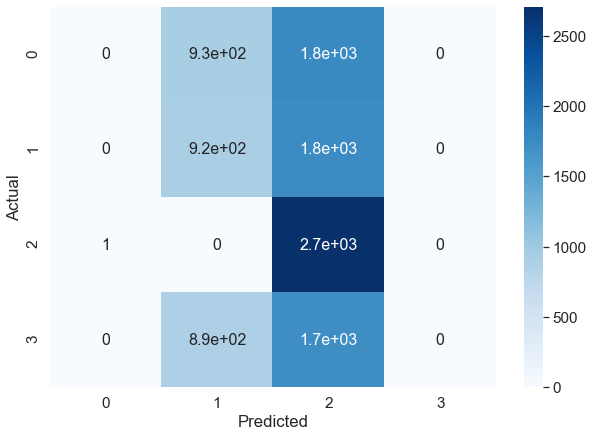

In [28]:
plot_confusion_matrix(dataset.get_all_labels(), pred)

## Training: Support Vector Machine

In [14]:
y = norm_data['origin']
X = norm_data.loc[:, norm_data.columns != 'origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,len,src_0.0,src_1.0,src_2.0,src_3.0
3231,0.793756,1.000000,0.915710,1.000000,0.000000,0.000000,0.609901,0.859089,0.097674,0,0,1,0
41582,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.004651,1,0,0,0
46119,0.914406,1.000000,0.731130,0.786052,0.000000,0.000000,0.643680,0.723384,0.176744,0,0,1,0
12081,0.625654,1.000000,0.000000,0.000000,0.810593,0.912759,0.700158,1.000000,0.065116,0,1,0,0
22311,0.765733,0.834061,0.000000,0.000000,0.600920,1.000000,1.000000,1.000000,0.060465,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.608534,0.890173,0.000000,0.000000,0.657362,0.863303,0.372946,0.736763,0.144186,0,1,0,0
44732,0.637162,1.000000,1.000000,1.000000,0.000000,0.000000,0.609582,1.000000,0.106977,0,0,1,0
38158,0.432406,0.727165,0.672455,0.032486,0.543576,0.023181,0.000000,0.000000,0.097674,0,0,0,1
860,1.000000,1.000000,0.842363,1.000000,0.000000,0.000000,0.476062,0.290715,0.009302,0,0,1,0


In [16]:
classifier = svm.SVC(probability=True)
classifier.fit(X_train, y_train)

SVC(probability=True)

In [17]:
classifier.score(X_test, y_test)

0.341214953271028

In [18]:
pred = classifier.predict(X_test)

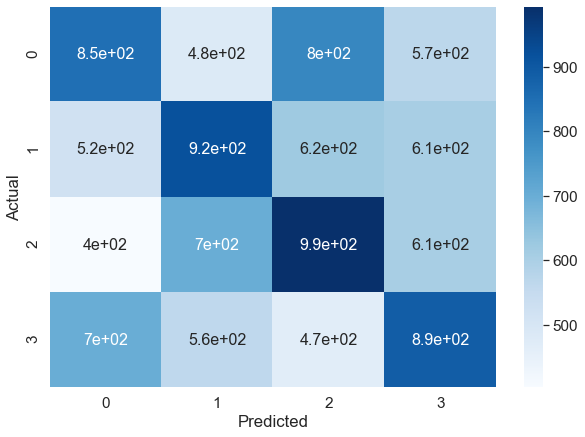

In [23]:
plot_confusion_matrix(y_test.values, pred)